In [3]:
import time
from itertools import combinations
import numpy as np
import cvxpy as cp
from opt import *

In [4]:
def matrix_pattern(pattern):
    n = len(pattern)
    pattern = np.reshape(pattern, (1, len(pattern)))
    X = (np.transpose(pattern) @ pattern) / 2
    for i in range(n):
         X[i, i] = pattern[0, i]
    return X

In [5]:
def l1_project(J, h, secure=1, margin=0.0):
    n = len(J)

    K = cp.Variable((n, n), symmetric=True)
    constraints = []
    for i in range(n):
        constraints += [K[i, i] == h[i]]
        for j in range(n):
            if i != j:
                constraints += [K[i, j] <= J[i, j]]
                constraints += [K[i, j] >= 0]

    # add all patterns with single infection
    cascade_pattern = np.ones(n)
    X1 = matrix_pattern(cascade_pattern)

    for k in range(1, secure+1):
        combs = combinations(range(n), k)
        for comb in combs:
            pattern = -1*np.ones(n)
            for el in comb:
                pattern[el] = 1
            X = matrix_pattern(pattern)
            constraints += [cp.sum(cp.multiply(K, X)) >= cp.sum(cp.multiply(K, X1)) + margin]

    # eliminate cascade case
    healthy_pattern = -1*np.ones(n)
    X0 = matrix_pattern(cascade_pattern)
    constraints += [cp.sum(cp.multiply(K, X0)) >= cp.sum(cp.multiply(K, X1)) + margin]

    # add projection objective
    prob = cp.Problem(cp.Minimize(cp.sum(J-K)), constraints)#+ cp.sum([h[i]-K[i, i] for i in range(len(J))])
    prob.solve(solver=cp.SCS, eps=1e-4)
    #print("K = ", K.value)
    
    new_J = K.value - np.diag(np.diag(K.value))
    new_h = np.diag(K.value)
    print("Optimal value: %s" % prob.value)

    return new_J, new_h

Now we read Seattle data, initialize the Ising model of pandemic, infect node 0 and compute the MAP state. As we can see, all MAP values are +1.

In [6]:
# prepare top20
#N = np.genfromtxt('chicago_travel_numbers.csv', delimiter=',')
#travel = np.sum(N, axis = 0)
#travel = np.argsort(travel)[::-1][:20]
#N = N[np.ix_(travel, travel)]

In [7]:
N = np.genfromtxt('seattle_top20_travel_numbers.csv', delimiter=',')#[:20, :20]
mu = 0.00012
h_max = -0.01
J = N * np.log(1 / (1 - mu))
h = h_max * np.ones(len(N))
result0 = gurobi_map_explicit(J, h, [0])
print(result0)

Academic license - for non-commercial use only - expires 2022-03-24
Using license file /home/mk/gurobi.lic

Statistics for model map :
  Linear constraint matrix    : 1 Constrs, 20 Vars, 1 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.248014, 1.38064 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  2.515642941834232
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [8]:
# here we compute l1 projection onto the Safe Polytope
start_time = time.time()
projected_J, projected_h = l1_project(J, h, secure=1, margin=0.000001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Optimal value: 1.946109692981462
Found projection in 1.232161283493042 sec.


In [9]:
result0 = gurobi_map_explicit(projected_J, h, [1])
print(result0)


Statistics for model map :
  Linear constraint matrix    : 1 Constrs, 20 Vars, 1 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.24801, 0.399999 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  1.6425892023967443
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_difference(diff_J):
    G = nx.convert_matrix.from_numpy_matrix(diff_J)
    np.random.seed(4812)
    pos = nx.random_layout(G)
    edges = G.edges()
    weights = [10*G[u][v]['weight'] for u,v in edges]

    nx.draw(G, pos, width=weights)
    plt.savefig("l1.png")

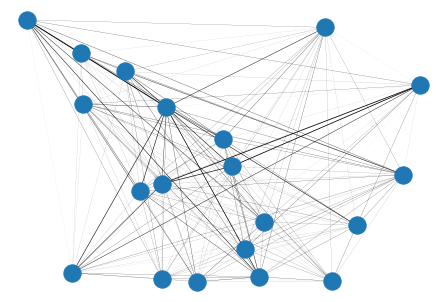

In [11]:
plot_difference(J)
np.savetxt("original_seattle.csv", J, delimiter=",")

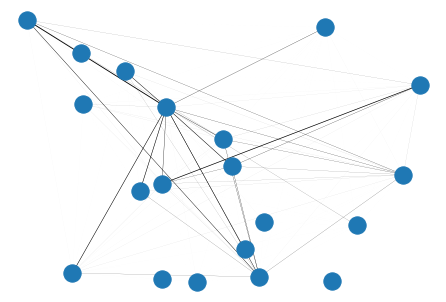

In [12]:
plot_difference(projected_J-J)
np.savetxt("difference_seattle_l1.csv", projected_J-J, delimiter=",")

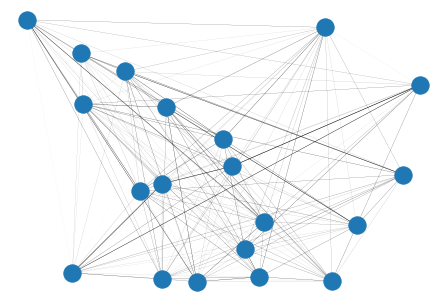

In [13]:
plot_difference(projected_J)
np.savetxt("projected_seattle_l1.csv", projected_J, delimiter=",")

In [14]:
print(J)
np.savetxt("original_seattle_l1.csv", J, delimiter=",")

[[0.         0.00408024 0.01764106 0.00984059 0.00744045 0.0183611
  0.01476089 0.00972058 0.00444027 0.01872112 0.00528032 0.00348021
  0.0049203  0.03096186 0.01752105 0.         0.00744045 0.02100126
  0.0033602  0.00792048]
 [0.00408024 0.         0.04920295 0.00516031 0.0033602  0.01608096
  0.04080245 0.00816049 0.00132008 0.00324019 0.00864052 0.00216013
  0.00468028 0.05568334 0.01548093 0.0067204  0.01704102 0.01608096
  0.00648039 0.00588035]
 [0.01764106 0.04920295 0.         0.01560094 0.00480029 0.06240374
  0.07464448 0.00768046 0.00432026 0.00228014 0.0082805  0.0067204
  0.00816049 0.03324199 0.00468028 0.00480029 0.0100806  0.00696042
  0.00204012 0.00624037]
 [0.00984059 0.00516031 0.01560094 0.         0.00960058 0.0066004
  0.00972058 0.00552033 0.01140068 0.01704102 0.01080065 0.00648039
  0.00516031 0.04308259 0.01596096 0.00180011 0.0066004  0.01632098
  0.         0.00708042]
 [0.00744045 0.0033602  0.00480029 0.00960058 0.         0.00456027
  0.01980119 0.0075

In [15]:
print(J-projected_J)

[[ 0.00000000e+00  3.34295094e-04  9.34567940e-04  1.69824560e-04
   1.82387311e-04  3.71563257e-04  9.88440284e-04  4.66690486e-04
   4.55738640e-09  2.37206937e-03  1.41918772e-04  2.00639063e-04
   3.24938347e-04  5.22043869e-03  2.19680172e-03 -4.80055806e-09
  -1.13604816e-10  2.66449819e-03  3.23780326e-04  8.64469339e-08]
 [ 3.34295094e-04  0.00000000e+00  3.37733692e-03  2.79592428e-04
   2.52857967e-04  1.05946723e-03  2.32336508e-03  3.88706043e-04
   2.54425391e-08  8.86181472e-04  1.64621558e-04  8.51652955e-04
   3.15669641e-04  5.47844654e-02  1.15000770e-02  3.10549038e-04
  -4.16101120e-08  2.87012329e-03  5.57730558e-04  9.62977388e-08]
 [ 9.34567940e-04  3.37733692e-03  0.00000000e+00  2.92356534e-04
   1.96141391e-04  1.69498585e-02  6.78452516e-02  4.43060306e-04
   1.12382372e-08  2.17155777e-03  2.11236435e-04  2.08113789e-03
   3.18091747e-04  3.30884285e-02  4.59146900e-03  1.29739608e-04
  -2.72117064e-08  6.84571506e-03  3.04299034e-04  9.91062531e-08]
 [ 1.69

In [16]:
print(projected_J)

[[ 0.00000000e+00  3.74594973e-03  1.67064905e-02  9.67076589e-03
   7.25805913e-03  1.79895384e-02  1.37724454e-02  9.25389276e-03
   4.44026186e-03  1.63490539e-02  5.13839805e-03  3.27956975e-03
   4.59535688e-03  2.57414191e-02  1.53242496e-02  4.80055806e-09
   7.44044655e-03  1.83367619e-02  3.03642129e-03  7.92038879e-03]
 [ 3.74594973e-03  0.00000000e+00  4.58256153e-02  4.88071720e-03
   3.10734365e-03  1.50214976e-02  3.84790831e-02  7.77178360e-03
   1.32005376e-03  2.35401294e-03  8.47589688e-03  1.30847666e-03
   4.36461118e-03  8.98875625e-04  3.98085190e-03  6.40985419e-03
   1.70410641e-02  1.32108416e-02  5.92265827e-03  5.88025653e-03]
 [ 1.67064905e-02  4.58256153e-02  0.00000000e+00  1.53085795e-02
   4.60414663e-03  4.54538858e-02  6.79922713e-03  7.23740053e-03
   4.32024798e-03  1.08579043e-04  8.06926040e-03  4.63926534e-03
   7.84239789e-03  1.53566017e-04  8.88118195e-05  4.67054841e-03
   1.00806321e-02  1.14702576e-04  1.73582338e-03  6.24027532e-03]
 [ 9.67

In [7]:
# here we compute l1 projection onto the Safe Polytope
start_time = time.time()
projected_J, projected_h = l1_project(J, h, secure=4, margin=0.001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

ValueError: Input must be 1- or 2-d.

Now, infecting node 0 does not create any other infections:

In [6]:
result = gurobi_map_explicit(projected_J, projected_h, [0])
print(result)


Statistics for model map :
  Linear constraint matrix    : 1 Constrs, 20 Vars, 1 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.398685, 0.398688 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  1.694667487964156
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0]


However, if two nodes are infected, then again all nodes are infected in MAP state:

In [7]:
result = gurobi_map_explicit(projected_J, projected_h, [0, 1])
print(result)


Statistics for model map :
  Linear constraint matrix    : 2 Constrs, 20 Vars, 2 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.398685, 0.398688 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  1.6936661864880764
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [8]:
# here we compute l1 projection onto the Safe Polytope(2)
start_time = time.time()
projected_J, projected_h = l1_project(J, h, secure=2, margin=0.001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Optimal value: 43.62073910350217
Found projection in 3.0805139541625977 sec.


In [9]:
result = gurobi_map_explicit(projected_J, projected_h, [0, 1])
print(result)


Statistics for model map :
  Linear constraint matrix    : 2 Constrs, 20 Vars, 2 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.195125, 0.210545 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  0.7309526900870025
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]


In [10]:
# here we compute l1 projection onto the Safe Polytope(3)
start_time = time.time()
projected_J, projected_h = l1_project(J, h, secure=3, margin=0.001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Optimal value: 44.308961587876254
Found projection in 11.08910083770752 sec.
